## Predict delta PSI of GTEx A5SS events with COSSMO

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

from mmsplice.exon_dataloader import ExonDataset

from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

%load_ext autoreload
%autoreload 2

projectDIR = "../../data/"

Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator HuberRegressor from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/l

In [2]:
dl1 = ExonDataset(projectDIR+"gtex/A5SS_SD1_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(40,40))

In [3]:
dl2 = ExonDataset(projectDIR+"gtex/A5SS_SD2_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(40,40))

In [4]:
dl1 = DataLoader(dl1, batch_size=dl1.__len__(), collate_fn=numpy_collate, shuffle=False)
dl1 = iter(dl1)
dt1 = next(dl1)

In [5]:
dl2 = DataLoader(dl2, batch_size=dl2.__len__(), collate_fn=numpy_collate, shuffle=False)
dl2 = iter(dl2)
dt2 = next(dl2)

In [6]:
csv = projectDIR+"gtex/A5SS_SD1_variant.csv"
csvf = pd.read_csv(csv, sep=',', index_col=0)
csvf = csvf.reset_index()

In [7]:
# WT_ACC: Exon with 40 nt flanking
csvf['WT_DONOR1'] = dt1['inputs']['seq']
csvf['WT_DONOR2'] = dt2['inputs']['seq']
csvf['MUT_DONOR1'] = dt1['mut_inputs']['seq']
csvf['MUT_DONOR2'] = dt2['mut_inputs']['seq']

## Process for COSSMO

In [8]:
import tensorflow as tf
from mmsplice.vcf_dataloader import FastaSeq
from mmsplice.IntervalTree import Interval

In [9]:
fasta = FastaSeq(projectDIR+'shared/hg19.fa')

In [10]:
from mmsplice.vcf_dataloader import FastaSeq
from mmsplice.IntervalTree import Interval

# fasta = FastaSeq(fasta, as_raw=False)
def get_constseq_donor(event, fasta):
    # return 1. alt ss positions, const pos
    # 2. const sequence
    event_split = event.split(":")
    strand = event_split[-1]
    if strand == "+":
        const_pos = int(event_split[-3])
        alt_ss_pos = event_split[2].split("|")
    else:
        const_pos = int(event_split[-2])
        alt_ss_pos = event_split[2].split("|")[::-1]
    alt_ss_pos = [int(i) for i in alt_ss_pos]
    chrom = event_split[0]
    if strand == "+":
        const = Interval(chrom=chrom, start=const_pos-40, end=const_pos+40-1, strand=strand)
    else:
        const = Interval(chrom=chrom, start=const_pos-40+1, end=const_pos+40, strand=strand)
        const_pos = -const_pos
        alt_ss_pos = [-i for i in alt_ss_pos]
    constseq = fasta.getSeq(const)
    return constseq, const_pos, alt_ss_pos

In [11]:
# process one row of csvf, return cossmo inputs
def cossmo_inputs(x, fasta, placeholder, wt=True):
    constseq, const_pos, alt_ss_pos = get_constseq_donor(x.event_name, fasta)
    if wt:
        DONOR1seq = x.WT_DONOR1
        DONOR2seq = x.WT_DONOR2
    else:
        DONOR1seq = x.MUT_DONOR1
        DONOR2seq = x.MUT_DONOR2
    alt_dna_seq = [DONOR1seq[-80:], DONOR2seq[-80:]]
    rns_seq = [DONOR1seq[:40]+constseq[40:80], DONOR2seq[:40]+constseq[40:80]]
    return {placeholders['alt_dna_seq']: alt_dna_seq,
            placeholders['const_site_position']: const_pos,
            placeholders['const_dna_seq']: constseq,
            placeholders['n_alt_ss']: 2,
            placeholders['alt_ss_position']: alt_ss_pos,
            placeholders['rna_seq']: rns_seq}

In [12]:
def transpose_collate(collate, placeholders):
    collate[placeholders['alt_dna_seq']] = np.array(collate[placeholders['alt_dna_seq']]).T
    collate[placeholders['alt_ss_position']] = np.array(collate[placeholders['alt_ss_position']]).T
    collate[placeholders['rna_seq']] = np.array(collate[placeholders['rna_seq']]).T
    return collate

In [13]:
session = tf.Session()
sm = tf.saved_model.loader.load(
  session, 
  [tf.saved_model.tag_constants.SERVING], 
  projectDIR+'COSSMO/saved_model_donor_lstm_1_fold0'
)
placeholders = {n.name[n.name.rfind('/') + 1:-2]: n
  for n in tf.get_collection('inputs')}
psi_prediction, logits = tf.get_collection('outputs')

INFO:tensorflow:Restoring parameters from ../../data/COSSMO/saved_model_donor_lstm_1_fold0/variables/variables


2018-11-16 17:18:59,492 [INFO] Restoring parameters from ../../data/COSSMO/saved_model_donor_lstm_1_fold0/variables/variables


In [14]:
WT_inputs = numpy_collate(csvf.apply(lambda x: cossmo_inputs(x, fasta, placeholders, wt=True), axis=1))
WT_inputs = transpose_collate(WT_inputs, placeholders)
pred_wt = session.run((psi_prediction, logits), feed_dict=WT_inputs)

In [15]:
MUT_inputs = numpy_collate(csvf.apply(lambda x: cossmo_inputs(x, fasta, placeholders, wt=False), axis=1))
MUT_inputs = transpose_collate(MUT_inputs, placeholders)
pred_mut = session.run((psi_prediction, logits), feed_dict=MUT_inputs)

## Plot

In [16]:
df = pd.read_csv(projectDIR+"gtex/A5SS_PSI.csv", index_col=0)
df = df.reset_index()

In [17]:
DPSI_PRED = pred_mut[0][0][:,1] - pred_wt[0][0][:,1]

In [18]:
df['DPSI_PRED_HOMO'] = pred_mut[0][0][:,1] - pred_wt[0][0][:,1]
df['DPSI_PRED_HETERO'] = (pred_mut[0][0][:,1] + pred_wt[0][0][:,1]) / 2 - pred_wt[0][0][:,1]

In [19]:
df.head()

,index,event_name,CHROM,variant_position,REF,ALT,HETERO_MEAN,WT_MEAN,HOMO_MEAN,DPSI_PRED_HOMO,DPSI_PRED_HETERO
0,0,chr7:99810756:99810576|99810646:-@chr7:9980901...,7,99810643,T,G,0.242292,0.197791,0.320097,-0.449987,-0.224993
1,1,chr7:99810756:99810646|99810670:-@chr7:9980901...,7,99810643,T,G,0.144643,0.229302,0.068097,0.380121,0.190060
2,2,chr17:80014162:80014267|80014426:+@chr17:80014...,17,80014272,G,GCC,0.678092,0.745537,0.776000,-0.034737,-0.017368
3,3,chr15:41799855:41799712|41799760:-@chr15:41799...,15,41799711,C,T,0.449375,0.426013,0.365000,-0.238776,-0.119388
4,4,chr3:10329629:10329786|10329790:+@chr3:1033375...,3,10329788,C,G,0.478750,0.426461,NaN,0.177567,0.088783


In [20]:
df_HOMO = df[~df.HOMO_MEAN.isna()]
df_HETERO = df[~df.HETERO_MEAN.isna()]

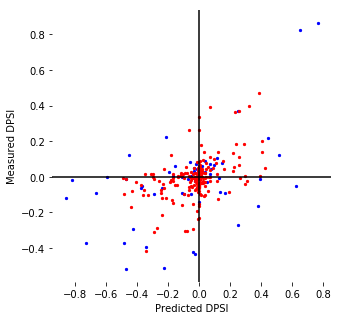

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['DPSI_PRED_HOMO'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['DPSI_PRED_HETERO'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [23]:
df_HOMO.to_csv(projectDIR + "gtex/COSSMO_SD_HOMO.csv")
df_HETERO.to_csv(projectDIR + "gtex/COSSMO_SD_HETERO.csv")